# 函数装饰器

函数装饰器是`可调用对象`，参数是`一个函数(被装饰的函数)`能把被装饰的函数替换成其他函数,或者处理被装饰的函数

    大多是装饰器会在 内部定义一个函数然后将其返回--替换被装饰的函数
    定义装饰器和定义被装饰的函数可以不在同一个模块中。通常在一个模块中定义装饰器，在其他模块中定义函数

In [3]:
# 定义一个名为deco的装饰器
def deco(func):#其参数是一个函数(被装饰的函数)
    # 定义了一个函数内的函数并返回，此函数会替换被装饰的函数
    def inner():
        print("inner running")
    return inner

# 定义被装饰的函数
def target():
    print("target running")

In [4]:
# 用法1
target = deco(target)  # 函数装饰器是可调用对象:调用deco(),传入对应的参数并获取其返回值
# target已经被改变了
target()

inner running


In [6]:
# deco返回了一个函数
a = deco(target)
a()

inner running


In [9]:
# 用法2
@deco
def target():# 被装饰的函数
    print("target running")

target()

inner running


装饰器在**加载模块时**立即执行:在被装饰的函数定义之后立即执行(无论是否被调用)

**注意区分导入时和运行时**

    导入时:import模块
    运行时:main()函数调用

下列代码将装饰器修饰的函数进行处理(存储在一个列表中)，而不是将装饰器函数进行替换
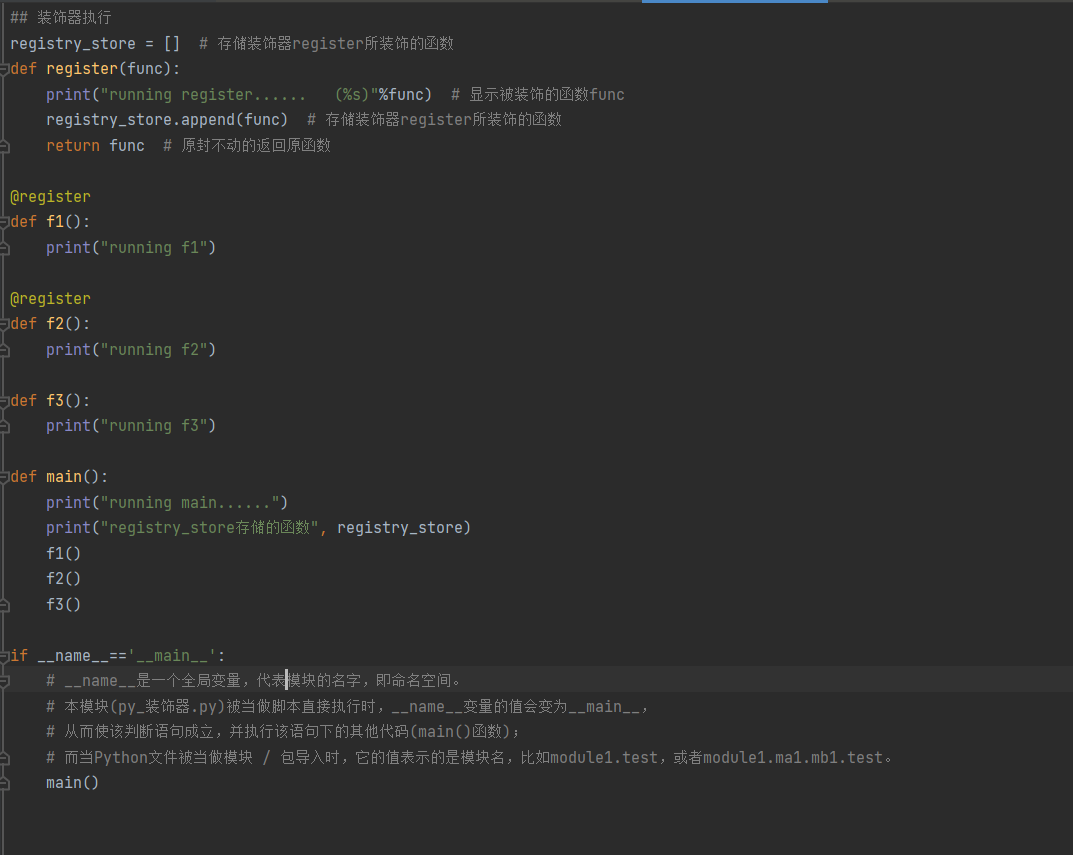
上述代码作为**脚本文件**运行时，会打印导入时的内容+运行时main()的内容

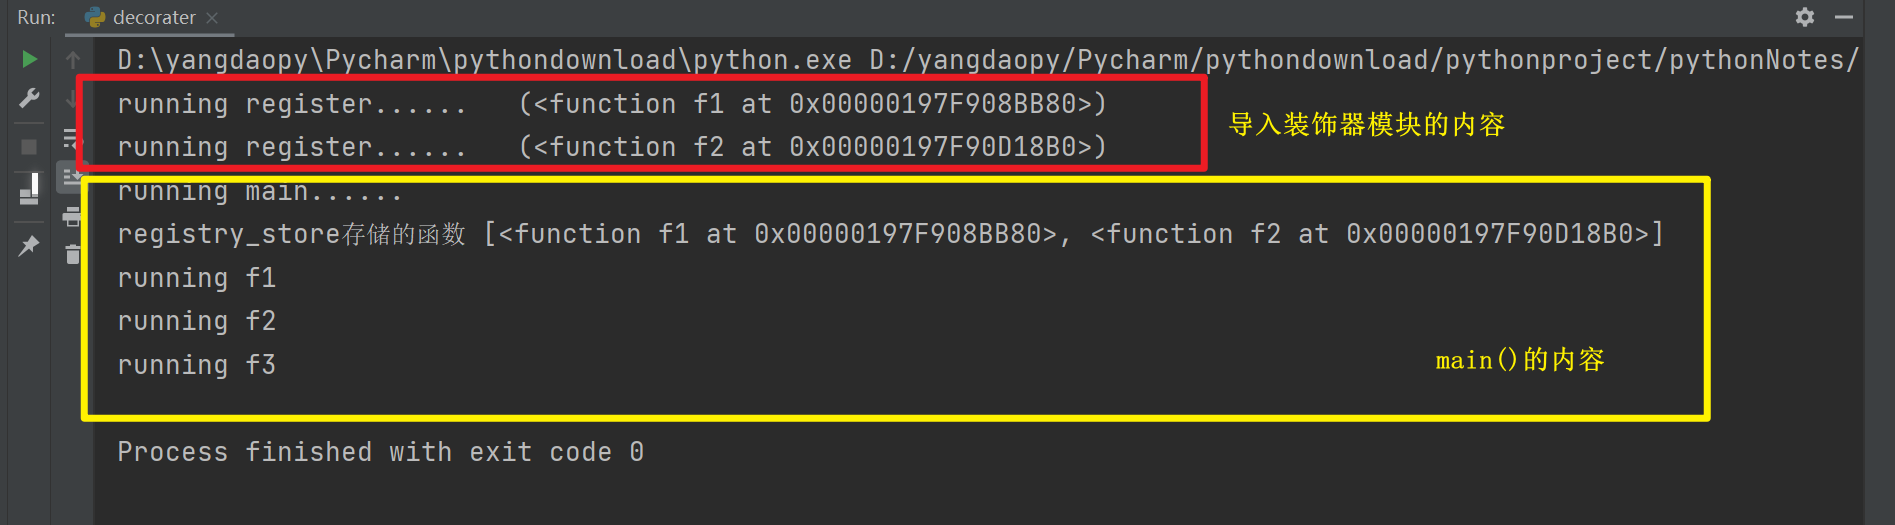

而作为模块导入时只会打印导入时的内容
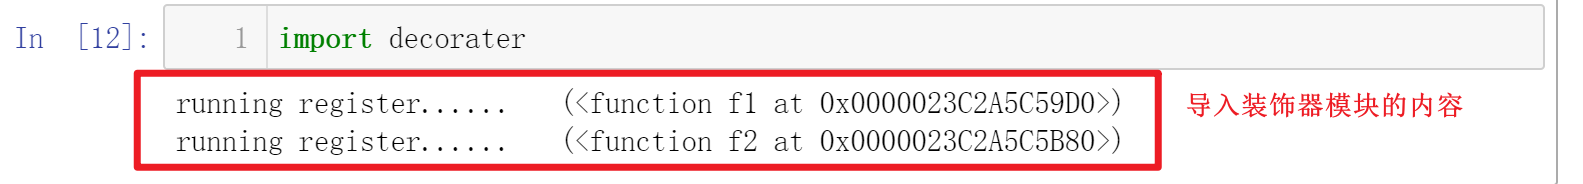

In [12]:
import decorater

running register......   (<function f1 at 0x0000023C2A5C59D0>)
running register......   (<function f2 at 0x0000023C2A5C5B80>)


# 变量作用域规则

In [14]:
def f1(a):
    # 函数内定义了一个局部变量a
    print(a)
    # 尝试打印一个变量b，由于函数没有定义它，会认为这是一个全局变量
    try:
        print(b)
    except Exception as e:
        print(e)
    
f1(666)

666
name 'b' is not defined


In [15]:
b = 6
def f2(a):
    print(a)
    print(b)  # b被视为全局变量

    
f2(666)

666
6


python不要求声明变量，但是假定在函数定义体中**赋值**的变量是局部变量

In [18]:
b = 6
def f3(a):
    print(a)
    # 尝试打印一个变量b，由于函数在后面定义它，会认为这是一个局部变量
    try:
        print(b)  # 在定义之前调用会报错
    except Exception as e:
        print(e)
    # 导致python判断这是一个局部变量    
    b = 999
    
f3(666)

666
local variable 'b' referenced before assignment


## 正确使用全局变量

如果在函数中赋值时想让解释器把 b 当成全局变量，要使用` global` 声明

In [22]:
b = 6
def f4(a):
    print(a)
    global b
    print(b)
    b = 999
    
f4(666)
print(b)

666
6
999


dis 模块为反汇编 Python 函数字节码提供了简单的方式

使用dis可以追踪变量类型

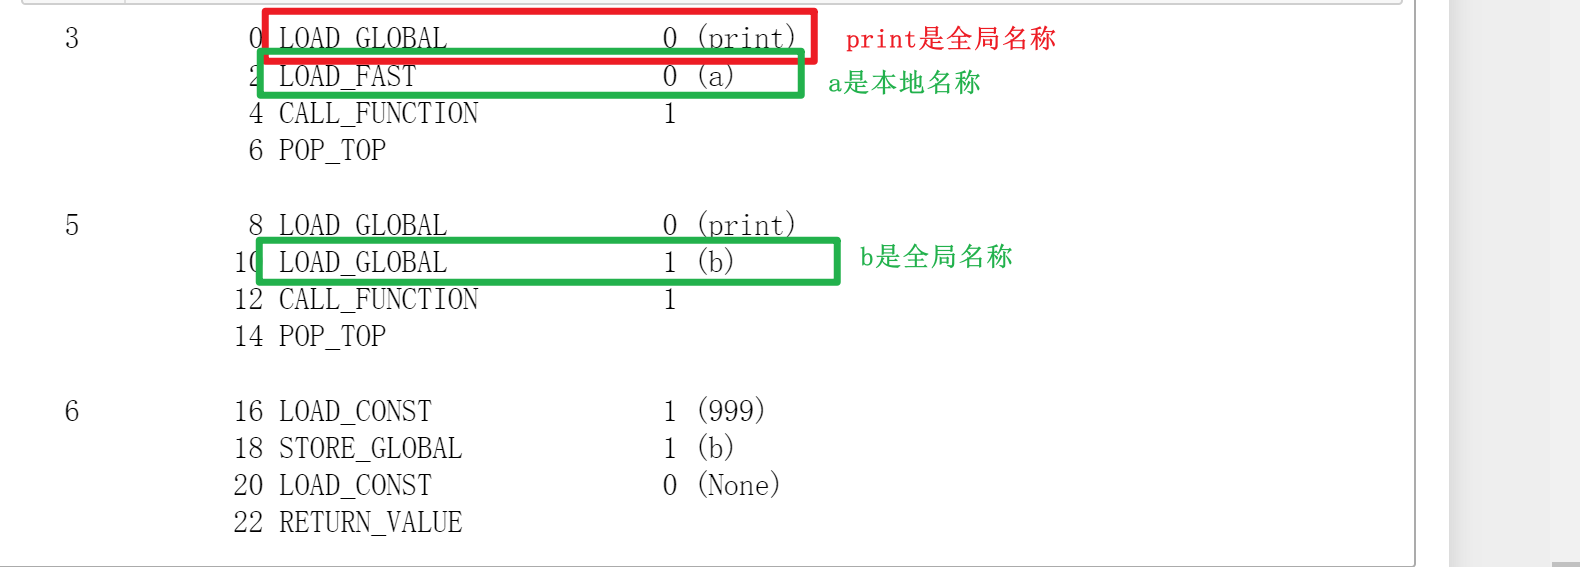

In [21]:
from dis import dis
dis(f4)

  3           0 LOAD_GLOBAL              0 (print)
              2 LOAD_FAST                0 (a)
              4 CALL_FUNCTION            1
              6 POP_TOP

  5           8 LOAD_GLOBAL              0 (print)
             10 LOAD_GLOBAL              1 (b)
             12 CALL_FUNCTION            1
             14 POP_TOP

  6          16 LOAD_CONST               1 (999)
             18 STORE_GLOBAL             1 (b)
             20 LOAD_CONST               0 (None)
             22 RETURN_VALUE


# 闭包与自由变量

对于下列嵌套函数：
    函数内的内部函数average()与函数中的局部变量series是什么关系？

In [26]:
def make_averager():
    """
    :return averager:返回定义的内部函数对象
    
    """
    # make_averager的局部变量
    series = []  # 与averager有何关系？
    def averager(new_value):# 不断加入的新值需要更新全局的平均值
        series.append(new_value)  # 将新值加入全局
        # 更新全局的平均值
        total = sum(series)
        return total /len(series)  # 返回均值
    
    return averager  # 注意返回的是内部函数

In [27]:
# 调用 make_averager 时，返回一个 内部函数对象(averager 函数对象)
avg = make_averager()
# 通过avg可以调用make_averager的内部函数对象averager
avg(10) # averager返回的是均值

10.0

分析：

    # 调用 make_averager 时，返回一个 内部函数对象(averager 函数对象)
    avg = make_averager()
    
上述说明，上述语句结束后，make_averager已经结束了，因为它已经return了其返回值(内部函数对象averager)

因此，既然函数已经返回结束了，make_averager的局部变量series也应该清空了才对

但是avg(也就是内部函数对象averager)却可以对series时刻保留历史值从而进行计算，这是为啥？

**原因**

series是averager的**自由变量**(未在本地作用域中绑定的变量)，

定义averager函数时自由变量的**绑定**会被保存起来，因此调用make_averager函数时虽然定义作用域不可用了，但是仍能使用**绑定**。

绑定存储在闭包中？__closure__存储了自由变量的绑定
    

In [29]:
# 观察averager函数的局部变量
avg.__code__.co_varnames   # 说明new_value、total是局部变量

('new_value', 'total')

In [30]:
# 观察averager函数的自由变量
avg.__code__.co_freevars  # 说明series是自由变量

('series',)

In [31]:
# 看自由变量的绑定--__closure__的元素
avg.__closure__  # __closure__的元素(cell对象)与co_freevars(自由变量)的名称一一对应

(<cell at 0x0000023C2A1B4D00: list object at 0x0000023C2CD13D40>,)

In [32]:
# cell_contents保存了自由变量的值
avg.__closure__[0].cell_contents  # avg.__closure__[0]-->avg只含一个绑定

[10]

In [33]:
# 随着更新，值不会清空
avg(11)
avg.__closure__[0].cell_contents

[10, 11]